# Imbalanced Classification

This notebooks contains results for various models in situations with varying amounts of class imbalance.

In [1]:
%reload_ext autoreload
%autoreload 2

import datetime as dt
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score

from gobbli.dataset.imdb import IMDBDataset
from gobbli.model.fasttext import FastText
from gobbli.model.bert import BERT
from gobbli.model.mtdnn import MTDNN
from gobbli.model.transformer import Transformer
from gobbli.util import pred_prob_to_pred_label
import pandas as pd

import benchmark
benchmark.init_benchmark_env()

In [2]:
ds = IMDBDataset.load()
X_train_valid, X_test = ds.X_train(), ds.X_test()
y_train_valid, y_test = ds.y_train(), ds.y_test()

In [3]:
def find_majority_minority_classes(y):
    majority, minority = pd.Series(y).value_counts().index.tolist()[:2]
    return majority, minority

majority, minority = find_majority_minority_classes(y_test)

def split_dataset(X, y):
    """
    Return the majority and minority sections of the dataset separately in dataframe form.
    """
    df = pd.DataFrame({"X": X, "y": y})

    minority_df = df[df['y'] == minority]

    # Downsample the majority so we start with a 50/50 split
    majority_df = df[df['y'] == majority].sample(n=minority_df.shape[0]).reset_index()

    return majority_df, minority_df

In [4]:
X_train_valid_fasttext, X_test_fasttext = benchmark.fasttext_preprocess(X_train_valid), benchmark.fasttext_preprocess(X_test)
X_train_valid_bert, X_test_bert = benchmark.bert_preprocess(X_train_valid), benchmark.bert_preprocess(X_test)

In [5]:
def analyze_all_results(model_cls, all_results, imbalance_proportions):
    minority_f1_scores = []
    majority_f1_scores = []
    for result in all_results:
        majority_f1, minority_f1 = f1_score(result.y_true, pred_prob_to_pred_label(result.y_pred_proba),
                                        average=None,
                                        labels=[majority, minority])
        minority_f1_scores.append(minority_f1)
        majority_f1_scores.append(majority_f1)        

    all_metrics = pd.DataFrame([{
        "imbalance_proportion": p,
        **r.metrics()
    } for p, r in zip(imbalance_proportions, all_results)])
    
    all_metrics['Minority Class F1 Score'] = minority_f1_scores
    all_metrics['Majority Class F1 Score'] = majority_f1_scores
    
    display(all_metrics)
    
    fig = plt.figure(figsize=(10, 10))
    minority_ax = fig.add_subplot()
    all_metrics.plot(x="imbalance_proportion", y="Minority Class F1 Score", ax=minority_ax)
    
    majority_ax = fig.add_subplot()
    all_metrics.plot(x="imbalance_proportion", y="Majority Class F1 Score", ax=majority_ax)
    
    plt.xlabel("Prevalence of Minority Class")
    plt.title(f"Model Performance by Prevalence of Minority Class - {model_cls.__name__}")
    plt.xlim(0, 0.5)
    plt.ylim(0, 1)
    
    plt.show()

def evaluate_model(model_cls, X, y, test_dataset, param_grid, imbalance_proportions, run_kwargs=None):
    all_results = []
    
    majority_df, minority_df = split_dataset(X, y)
    
    for proportion in imbalance_proportions:
        # Downsample the minority class so the final dataset contains the desired
        # proportion of the minority
        orig_len = majority_df.shape[0]
        downsample_proportion = -orig_len / (orig_len - orig_len/proportion)
        minority_sample = minority_df.sample(frac=downsample_proportion).reset_index()
        sampled_df = pd.concat([majority_df, minority_sample])
        
        X = sampled_df['X'].tolist()
        y = sampled_df['y'].tolist()
        
        print(f"{dt.datetime.now().strftime('[%Y-%m-%d %H:%M:%S]')} "
              f"Evaluating proportion {round(proportion, 3)} ({len(X)} obs)")
        
        results = benchmark.run_benchmark_experiment(
            f"classimbalance_{model_cls.__name__}",
            X,
            y,
            model_cls,
            param_grid,
            test_dataset=test_dataset,
            run_kwargs=run_kwargs
        )
        all_results.append(results)
    
    analyze_all_results(model_cls, all_results, imbalance_proportions)
    return all_results

In [6]:
IMBALANCE_PROPORTIONS = [0.01, 0.05, 0.1, 0.25, 0.33, 0.5]

[2019-08-20 22:05:02] Evaluating proportion 0.01 (12626 obs)
[2019-08-20 22:05:29] Evaluating proportion 0.05 (13158 obs)
[2019-08-20 22:05:58] Evaluating proportion 0.1 (13889 obs)
[2019-08-20 22:06:28] Evaluating proportion 0.25 (16667 obs)
[2019-08-20 22:06:57] Evaluating proportion 0.33 (18657 obs)
[2019-08-20 22:07:29] Evaluating proportion 0.5 (25000 obs)


,imbalance_proportion,Weighted F1 Score,Weighted Precision Score,Weighted Recall Score,Accuracy,Minority Class F1 Score,Majority Class F1 Score
0,0.01,0.334470,0.714406,0.50048,0.50048,0.002078,0.666862
1,0.05,0.644850,0.792836,0.67928,0.67928,0.534270,0.755429
2,0.10,0.721957,0.816047,0.73892,0.73892,0.653280,0.790634
3,0.25,0.849927,0.860895,0.85096,0.85096,0.837477,0.862377
4,0.33,0.864493,0.869576,0.86492,0.86492,0.856889,0.872098
5,0.50,0.875668,0.875823,0.87568,0.87568,0.876882,0.874455


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


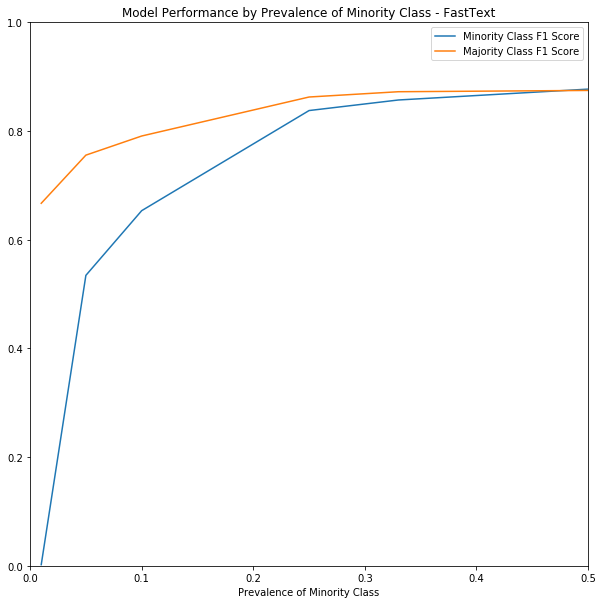

In [7]:
evaluate_model(FastText, X_train_valid_fasttext, y_train_valid, (X_test_fasttext, y_test), {
    "word_ngrams": [1],
    "dim": [100, 300],
    "lr": [0.5, 0.75, 1.0]
}, IMBALANCE_PROPORTIONS);

[2019-08-20 22:08:05] Evaluating proportion 0.01 (12626 obs)
(pid=2383) /code/gobbli/model/mtdnn/model.py:193: UserWarning: MT-DNN model does not support separate validation batch size; using train batch size '16' for both training and validation.
(pid=2383)   "MT-DNN model does not support separate validation batch size; "
[2019-08-20 22:43:07] Evaluating proportion 0.05 (13158 obs)
(pid=2688) /code/gobbli/model/mtdnn/model.py:193: UserWarning: MT-DNN model does not support separate validation batch size; using train batch size '16' for both training and validation.
(pid=2688)   "MT-DNN model does not support separate validation batch size; "
[2019-08-20 23:08:32] Evaluating proportion 0.1 (13889 obs)
(pid=2984) /code/gobbli/model/mtdnn/model.py:193: UserWarning: MT-DNN model does not support separate validation batch size; using train batch size '16' for both training and validation.
(pid=2984)   "MT-DNN model does not support separate validation batch size; "
[2019-08-20 23:35:29] E

,imbalance_proportion,Weighted F1 Score,Weighted Precision Score,Weighted Recall Score,Accuracy,Minority Class F1 Score,Majority Class F1 Score
0,0.01,0.552529,0.778454,0.61728,0.61728,0.382311,0.722747
1,0.05,0.739299,0.823057,0.75336,0.75336,0.678754,0.799844
2,0.10,0.791575,0.841634,0.79820,0.79820,0.754418,0.828733
3,0.25,0.860182,0.870596,0.86108,0.86108,0.848980,0.871385
4,0.33,0.867987,0.874070,0.86848,0.86848,0.859918,0.876055
5,0.50,0.882512,0.882621,0.88252,0.88252,0.881558,0.883466


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


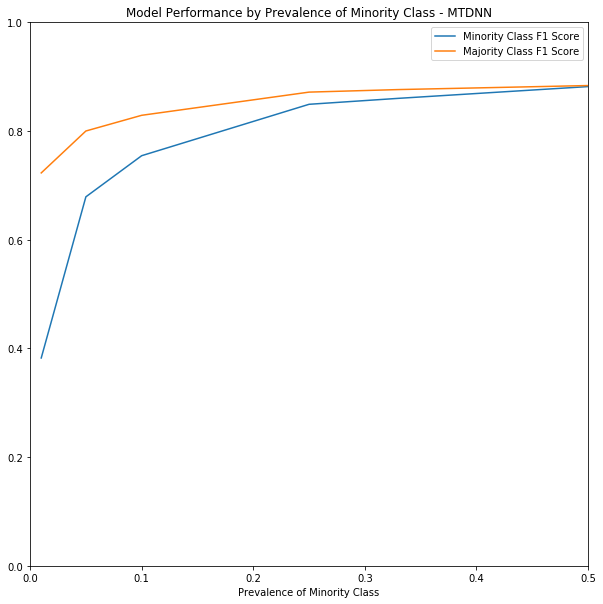

In [8]:
evaluate_model(MTDNN, X_train_valid_bert, y_train_valid, (X_test_bert, y_test), {
    "mtdnn_model": ["mt-dnn-base"],
    "max_seq_length": [128],
}, IMBALANCE_PROPORTIONS, run_kwargs={"train_batch_size": 16});

[2019-08-21 01:28:12] Evaluating proportion 0.01 (12626 obs)
[2019-08-21 01:47:09] Evaluating proportion 0.05 (13158 obs)
[2019-08-21 02:06:18] Evaluating proportion 0.1 (13889 obs)
[2019-08-21 02:26:13] Evaluating proportion 0.25 (16667 obs)
[2019-08-21 02:49:13] Evaluating proportion 0.33 (18657 obs)
[2019-08-21 03:14:19] Evaluating proportion 0.5 (25000 obs)


,imbalance_proportion,Weighted F1 Score,Weighted Precision Score,Weighted Recall Score,Accuracy,Minority Class F1 Score,Majority Class F1 Score
0,0.01,0.510295,0.767030,0.59100,0.59100,0.311494,0.709096
1,0.05,0.690307,0.806081,0.71368,0.71368,0.605228,0.775386
2,0.10,0.791156,0.841220,0.79780,0.79780,0.753907,0.828406
3,0.25,0.850778,0.863476,0.85196,0.85196,0.837497,0.864059
4,0.33,0.866598,0.872959,0.86712,0.86712,0.858252,0.874944
5,0.50,0.881168,0.881611,0.88120,0.88120,0.879219,0.883117


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


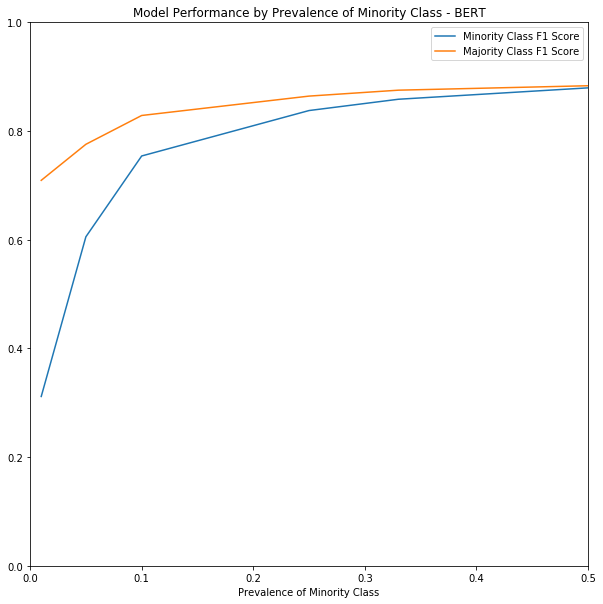

In [9]:
evaluate_model(BERT, X_train_valid_bert, y_train_valid, (X_test_bert, y_test), {
    "bert_model": ["bert-base-uncased"],
    "max_seq_length": [128],
}, IMBALANCE_PROPORTIONS);

[2019-08-21 03:46:29] Evaluating proportion 0.01 (12626 obs)
[2019-08-21 04:26:31] Evaluating proportion 0.05 (13158 obs)
[2019-08-21 05:09:19] Evaluating proportion 0.1 (13889 obs)
[2019-08-21 05:53:24] Evaluating proportion 0.25 (16667 obs)
[2019-08-21 06:46:14] Evaluating proportion 0.33 (18657 obs)
[2019-08-21 07:43:24] Evaluating proportion 0.5 (25000 obs)


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,imbalance_proportion,Weighted F1 Score,Weighted Precision Score,Weighted Recall Score,Accuracy,Minority Class F1 Score,Majority Class F1 Score
0,0.01,0.337522,0.596958,0.50116,0.50116,0.008270,0.666774
1,0.05,0.529814,0.741822,0.59916,0.59916,0.349243,0.710384
2,0.10,0.333333,0.250000,0.50000,0.50000,0.000000,0.666667
3,0.25,0.333333,0.250000,0.50000,0.50000,0.000000,0.666667
4,0.33,0.333333,0.250000,0.50000,0.50000,0.000000,0.666667
5,0.50,0.333333,0.250000,0.50000,0.50000,0.000000,0.666667


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


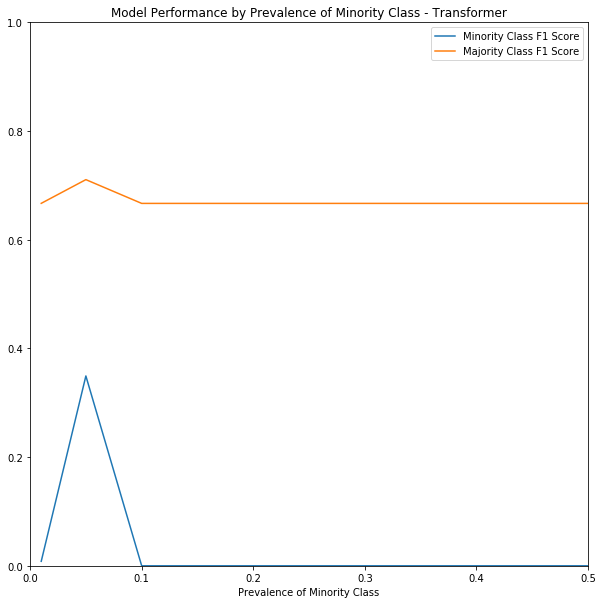

In [10]:
evaluate_model(Transformer, X_train_valid_bert, y_train_valid, (X_test_bert, y_test), {
    "transformer_weights": ["xlm-mlm-tlm-xnli15-1024", "xlm-clm-ende-1024"],
    "transformer_model": ["XLM"],
}, IMBALANCE_PROPORTIONS, run_kwargs={"train_batch_size": 16});

[2019-08-21 09:00:39] Evaluating proportion 0.01 (12626 obs)
[2019-08-21 09:24:26] Evaluating proportion 0.05 (13158 obs)
[2019-08-21 09:49:15] Evaluating proportion 0.1 (13889 obs)
[2019-08-21 10:15:26] Evaluating proportion 0.25 (16667 obs)
[2019-08-21 10:45:54] Evaluating proportion 0.33 (18657 obs)
[2019-08-21 11:19:50] Evaluating proportion 0.5 (25000 obs)


,imbalance_proportion,Weighted F1 Score,Weighted Precision Score,Weighted Recall Score,Accuracy,Minority Class F1 Score,Majority Class F1 Score
0,0.01,0.333333,0.250000,0.50000,0.50000,0.000000,0.666667
1,0.05,0.449388,0.750836,0.55620,0.55620,0.206877,0.691900
2,0.10,0.767928,0.827710,0.77692,0.77692,0.722247,0.813609
3,0.25,0.871911,0.880788,0.87260,0.87260,0.862520,0.881303
4,0.33,0.881434,0.884870,0.88168,0.88168,0.876037,0.886831
5,0.50,0.890713,0.890822,0.89072,0.89072,0.889830,0.891596


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


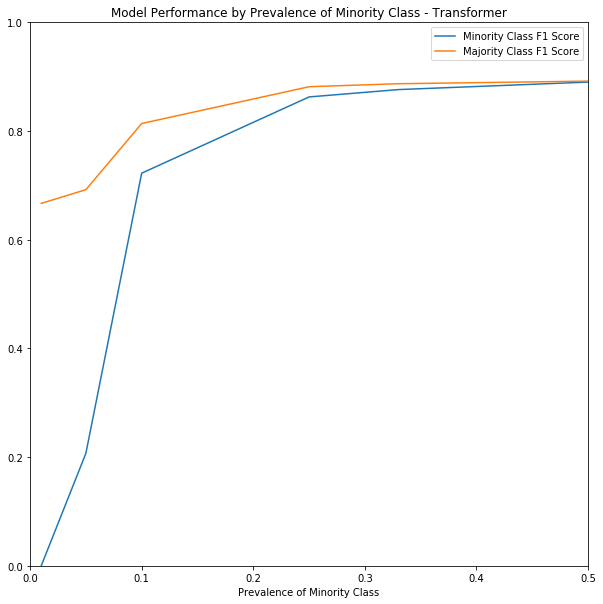

In [11]:
evaluate_model(Transformer, X_train_valid_bert, y_train_valid, (X_test_bert, y_test), {
    "transformer_weights": ["xlnet-base-cased"],
    "transformer_model": ["XLNet"],
}, IMBALANCE_PROPORTIONS, run_kwargs={"train_batch_size": 16});

[2019-08-21 12:03:50] Evaluating proportion 0.01 (12626 obs)
[2019-08-21 12:21:31] Evaluating proportion 0.05 (13158 obs)
[2019-08-21 12:40:09] Evaluating proportion 0.1 (13889 obs)
[2019-08-21 12:59:38] Evaluating proportion 0.25 (16667 obs)
[2019-08-21 13:23:03] Evaluating proportion 0.33 (18657 obs)
[2019-08-21 13:47:56] Evaluating proportion 0.5 (25000 obs)


,imbalance_proportion,Weighted F1 Score,Weighted Precision Score,Weighted Recall Score,Accuracy,Minority Class F1 Score,Majority Class F1 Score
0,0.01,0.333333,0.250000,0.50000,0.50000,0.000000,0.666667
1,0.05,0.333333,0.250000,0.50000,0.50000,0.000000,0.666667
2,0.10,0.333333,0.250000,0.50000,0.50000,0.000000,0.666667
3,0.25,0.333333,0.250000,0.50000,0.50000,0.000000,0.666667
4,0.33,0.883104,0.886748,0.88336,0.88336,0.877633,0.888575
5,0.50,0.888199,0.888216,0.88820,0.88820,0.887837,0.888561


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


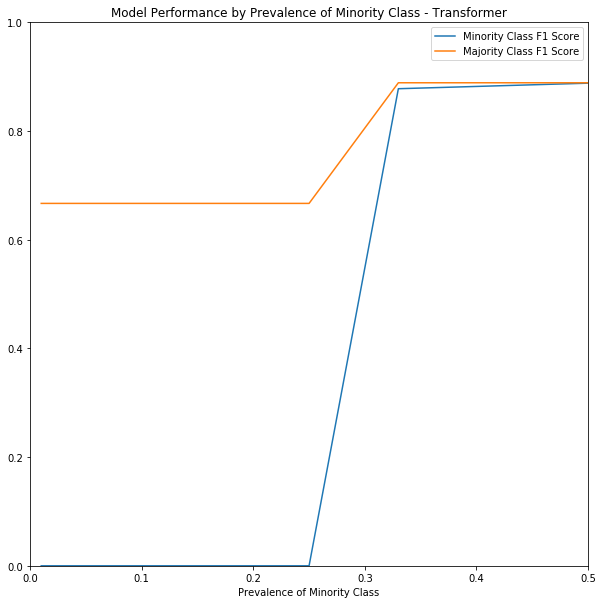

In [12]:
evaluate_model(Transformer, X_train_valid_bert, y_train_valid, (X_test_bert, y_test), {
    "transformer_weights": ["roberta-base"],
    "transformer_model": ["Roberta"],
}, IMBALANCE_PROPORTIONS, run_kwargs={"train_batch_size": 16});